In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

/Users/reghunotraghu/Documents/college_projects/dl-group-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Set seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [6]:
# Load & Preprocess Data
df = pd.read_csv('../starbucks_open_7year.csv')
df.ffill(inplace=True)
df['Log_Open'] = np.log(df['Open'])

In [7]:
# Smooth the data
df['Smoothed_Log_Open'] = df['Log_Open'].rolling(window=3).mean().fillna(df['Log_Open'])
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)


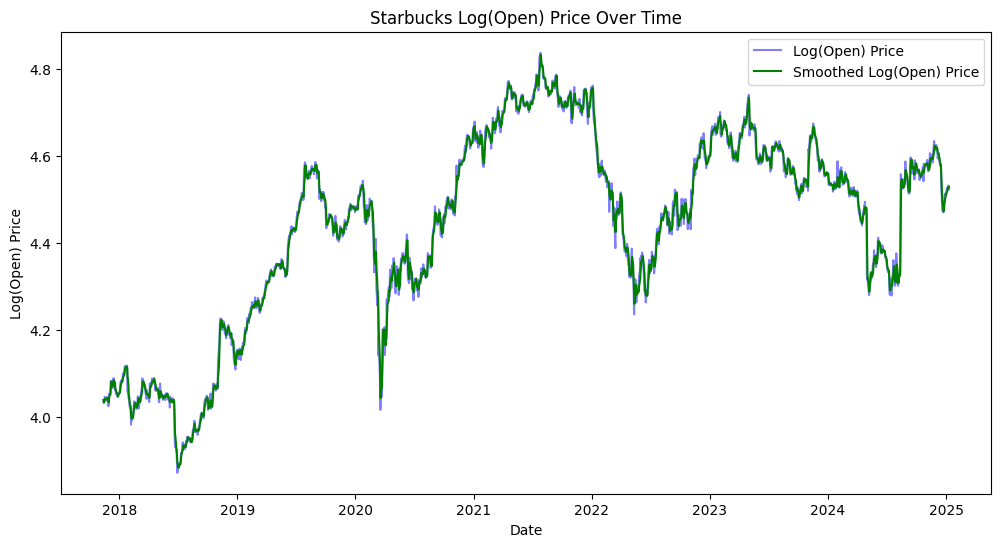

In [8]:
# Visualizing
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Open'], label='Log(Open) Price', color='blue', alpha=0.5)
plt.plot(df['Smoothed_Log_Open'], label='Smoothed Log(Open) Price', color='green')
plt.title('Starbucks Log(Open) Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log(Open) Price')
plt.legend()
plt.show()

In [9]:
# Scaling the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Smoothed_Log_Open']])

In [10]:
# Creating features
def create_lag_features(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_lag_features(scaled, window=30)

In [11]:
#Train,Validation,Test split 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

#reshape
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [12]:
#Building an improved DNN model(Regression Model)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_flat.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/Users/reghunotraghu/Documents/college_projects/dl-group-project/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
#Training the model
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5277 - mae: 0.4186 - val_loss: 0.5023 - val_mae: 0.5597 - learning_rate: 5.0000e-04
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2690 - mae: 0.2315 - val_loss: 0.3518 - val_mae: 0.4312 - learning_rate: 5.0000e-04
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2192 - mae: 0.1916 - val_loss: 0.2758 - val_mae: 0.3562 - learning_rate: 5.0000e-04
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1963 - mae: 0.1795 - val_loss: 0.2195 - val_mae: 0.2872 - learning_rate: 5.0000e-04
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1700 - mae: 0.1473 - val_loss: 0.1835 - val_mae: 0.2323 - learning_rate: 5.0000e-04
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1600 - mae: 0.1430 - val_loss: 0.1546 - val_mae: 0.1753 - learning_rate: 5.0000e-04
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1510 - mae: 0.1351 - val_loss: 0.1335 - val_mae: 0.1186 - learning_ra

In [14]:
y_pred_scaled = model.predict(X_test_flat)

#Scaled prediction
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_scaled),
    'MSE': mean_squared_error(y_test, y_pred_scaled),
    'R²': r2_score(y_test, y_pred_scaled),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_scaled)
}

print("\n[Scaled Evaluation]")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

[Scaled Evaluation]
MAE: 0.0157
MSE: 0.0005
R²: 0.9613
MAPE: 0.0271


In [ ]:
#Actual predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

inv_metrics = {
    'MAE': mean_absolute_error(y_test_actual, y_pred_actual),
    'MSE': mean_squared_error(y_test_actual, y_pred_actual),
    'R²': r2_score(y_test_actual, y_pred_actual),
    'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual)
}

print("\n[Inverse Scaled Evaluation]")
for metric, value in inv_metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
#Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot Actual and predicted price
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Price', color='orange')
plt.title('Starbucks Log(Open) Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()